In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100
loss_weights = (1.0, 1.0, .01, .01)

In [3]:
#LOAD DATASET

dataset = torch.load("dataset.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

class MultiTaskV3(nn.Module):
    def __init__(self):
        super().__init__()

        self.cloud_mask_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=1,
        )

        self.cloud_phase_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )
        self.cod_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )
        self.cps_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )

        self.conv0 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)


    def forward(self, x):
        x = F.relu(self.conv0(x))
        cloud_mask_pred = self.cloud_mask_net(x)
        cloud_phase_pred = self.cloud_phase_net(x)
        cod_pred = self.cod_net(x)
        cps_pred = self.cps_net(x)

        cloud_phase_pred = torch.cat([cloud_mask_pred, cloud_phase_pred], dim=1)
        cod_pred = torch.cat([cloud_mask_pred, cod_pred], dim=1)
        cps_pred = torch.cat([cloud_mask_pred, cps_pred], dim=1)

        cloud_phase_pred = F.relu(self.conv1(cloud_phase_pred))
        cod_pred = F.relu(self.conv2(cod_pred))
        cps_pred = F.relu(self.conv3(cps_pred))

        return cloud_mask_pred, cloud_phase_pred, cod_pred, cps_pred



In [6]:
#FINAL SETUP

dev_str = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev_str)
model = MultiTaskV3().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler(device = device)

def unpack_labels(labels):
    return (
        labels[:, 0:1, :, :],             # cloud_mask → [B, H, W]
        labels[:, 1, :, :].long(),        # cloud_phase → [B, H, W]
        labels[:, 2:3, :, :],             # cod → [B, 1, H, W]
        labels[:, 3:4, :, :]              # cps → [B, 1, H, W]
    )


train_mask_losses, train_phase_losses, train_cod_losses, train_cps_losses, train_all_losses = [], [], [], [], []
val_mask_losses, val_phase_losses, val_cod_losses, val_cps_losses, val_all_losses = [], [], [], [], []

train_mask_acc, train_phase_acc, train_cod_r2, train_cps_r2 = [], [], [], []
val_mask_acc, val_phase_acc, val_cod_r2, val_cps_r2 = [], [], [], []

In [7]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader, loss_weights=(1,1,1,1)):
    model.train()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        optimizer.zero_grad()
        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        with autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            

        # Update model
        scaler.scale(total_batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(train_loader),
        'loss_mask': total_loss_mask / len(train_loader),
        'loss_phase': total_loss_phase / len(train_loader),
        'loss_cod': total_loss_cod / len(train_loader),
        'loss_cps': total_loss_cps / len(train_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }



def eval(model, val_loader, loss_weights=(1,1,1,1)):
    model.eval()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        
        with torch.no_grad(), autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            
        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(val_loader),
        'loss_mask': total_loss_mask / len(val_loader),
        'loss_phase': total_loss_phase / len(val_loader),
        'loss_cod': total_loss_cod / len(val_loader),
        'loss_cps': total_loss_cps / len(val_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }

In [8]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_results = train(model, train_loader, loss_weights = loss_weights)
    val_results = eval(model, val_loader, loss_weights = loss_weights)
    
    train_mask_losses.append(train_results['loss_mask'])
    train_phase_losses.append(train_results['loss_phase'])
    train_cod_losses.append(train_results['loss_cod'])
    train_cps_losses.append(train_results['loss_cps'])
    train_all_losses.append(train_results['loss_total'])

    train_mask_acc.append(train_results['acc_mask'])
    train_phase_acc.append(train_results['acc_phase'])
    train_cod_r2.append(train_results['r2_cod'])
    train_cps_r2.append(train_results['r2_cps'])

    val_mask_losses.append(val_results['loss_mask'])
    val_phase_losses.append(val_results['loss_phase'])
    val_cod_losses.append(val_results['loss_cod'])
    val_cps_losses.append(val_results['loss_cps'])
    val_all_losses.append(val_results['loss_total'])

    val_mask_acc.append(val_results['acc_mask'])
    val_phase_acc.append(val_results['acc_phase'])
    val_cod_r2.append(val_results['r2_cod'])
    val_cps_r2.append(val_results['r2_cps'])

    print(f"Epoch: {e} | Train Loss: {train_results['loss_total']:.4f} | Val Loss: {val_results['loss_total']:.4f} | Val Mask: {val_results['acc_mask']:.4f} | Val Phase: {val_results['acc_phase']:.4f} | Val Cod: {val_results['r2_cod']:.4f} | Val Cps: {val_results['r2_cps']:.4f}")
    

100%|██████████| 94/94 [00:32<00:00,  2.91it/s]


Epoch: 1 | Train Loss: 4.8159 | Val Loss: 4.6722 | Val Mask: 0.8201 | Val Phase: 0.3073 | Val Cod: -0.2539 | Val Cps: -0.9043


100%|██████████| 94/94 [00:29<00:00,  3.16it/s]


Epoch: 2 | Train Loss: 4.2792 | Val Loss: 4.1040 | Val Mask: 0.7970 | Val Phase: 0.5739 | Val Cod: -0.1034 | Val Cps: -0.6736


100%|██████████| 94/94 [00:28<00:00,  3.32it/s]


Epoch: 3 | Train Loss: 3.8403 | Val Loss: 4.7172 | Val Mask: 0.8243 | Val Phase: 0.4300 | Val Cod: -0.2307 | Val Cps: -0.9920


100%|██████████| 94/94 [00:28<00:00,  3.36it/s]


Epoch: 4 | Train Loss: 3.4543 | Val Loss: 3.2863 | Val Mask: 0.9067 | Val Phase: 0.6407 | Val Cod: -0.0823 | Val Cps: -0.2032


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 5 | Train Loss: 3.0901 | Val Loss: 3.5374 | Val Mask: 0.8754 | Val Phase: 0.5695 | Val Cod: -0.0450 | Val Cps: -0.3254


100%|██████████| 94/94 [00:27<00:00,  3.40it/s]


Epoch: 6 | Train Loss: 2.7692 | Val Loss: 2.6808 | Val Mask: 0.9039 | Val Phase: 0.6711 | Val Cod: -0.0658 | Val Cps: 0.0933


100%|██████████| 94/94 [00:27<00:00,  3.40it/s]


Epoch: 7 | Train Loss: 2.4918 | Val Loss: 3.2583 | Val Mask: 0.8579 | Val Phase: 0.4491 | Val Cod: 0.0451 | Val Cps: 0.2249


100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Epoch: 8 | Train Loss: 2.2865 | Val Loss: 2.7648 | Val Mask: 0.8594 | Val Phase: 0.6414 | Val Cod: -0.2000 | Val Cps: 0.1144


100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Epoch: 9 | Train Loss: 2.1328 | Val Loss: 3.4293 | Val Mask: 0.9042 | Val Phase: 0.4105 | Val Cod: 0.1451 | Val Cps: 0.1042


100%|██████████| 94/94 [00:27<00:00,  3.43it/s]


Epoch: 10 | Train Loss: 1.9838 | Val Loss: 2.1475 | Val Mask: 0.9172 | Val Phase: 0.8065 | Val Cod: 0.0097 | Val Cps: 0.3218


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 11 | Train Loss: 1.8063 | Val Loss: 2.6451 | Val Mask: 0.9435 | Val Phase: 0.7382 | Val Cod: 0.1999 | Val Cps: -0.1050


100%|██████████| 94/94 [00:27<00:00,  3.36it/s]


Epoch: 12 | Train Loss: 1.6557 | Val Loss: 2.2514 | Val Mask: 0.8944 | Val Phase: 0.7344 | Val Cod: 0.1618 | Val Cps: 0.3032


100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Epoch: 13 | Train Loss: 1.5497 | Val Loss: 1.9274 | Val Mask: 0.9456 | Val Phase: 0.8111 | Val Cod: 0.1355 | Val Cps: 0.3029


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 14 | Train Loss: 1.4598 | Val Loss: 1.7564 | Val Mask: 0.9461 | Val Phase: 0.8104 | Val Cod: 0.2540 | Val Cps: 0.4007


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 15 | Train Loss: 1.4000 | Val Loss: 2.3743 | Val Mask: 0.9255 | Val Phase: 0.8181 | Val Cod: -0.8266 | Val Cps: 0.2555


100%|██████████| 94/94 [00:27<00:00,  3.43it/s]


Epoch: 16 | Train Loss: 1.3514 | Val Loss: 1.8456 | Val Mask: 0.9346 | Val Phase: 0.8089 | Val Cod: 0.0191 | Val Cps: 0.4051


100%|██████████| 94/94 [00:29<00:00,  3.23it/s]


Epoch: 17 | Train Loss: 1.3167 | Val Loss: 2.0121 | Val Mask: 0.9388 | Val Phase: 0.8028 | Val Cod: 0.2396 | Val Cps: 0.2087


100%|██████████| 94/94 [00:28<00:00,  3.30it/s]


Epoch: 18 | Train Loss: 1.2892 | Val Loss: 1.9246 | Val Mask: 0.9305 | Val Phase: 0.7874 | Val Cod: -0.0868 | Val Cps: 0.4333


100%|██████████| 94/94 [00:28<00:00,  3.33it/s]


Epoch: 19 | Train Loss: 1.2632 | Val Loss: 1.8642 | Val Mask: 0.9158 | Val Phase: 0.8201 | Val Cod: 0.1551 | Val Cps: 0.3044


100%|██████████| 94/94 [00:27<00:00,  3.43it/s]


Epoch: 20 | Train Loss: 1.2234 | Val Loss: 1.7388 | Val Mask: 0.9476 | Val Phase: 0.8043 | Val Cod: 0.2741 | Val Cps: 0.3836


100%|██████████| 94/94 [00:28<00:00,  3.33it/s]


Epoch: 21 | Train Loss: 1.2017 | Val Loss: 2.0010 | Val Mask: 0.9330 | Val Phase: 0.7874 | Val Cod: -0.0618 | Val Cps: 0.3649


100%|██████████| 94/94 [00:27<00:00,  3.37it/s]


Epoch: 22 | Train Loss: 1.1802 | Val Loss: 1.6856 | Val Mask: 0.9449 | Val Phase: 0.8292 | Val Cod: 0.2508 | Val Cps: 0.3463


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 23 | Train Loss: 1.1616 | Val Loss: 1.6545 | Val Mask: 0.9361 | Val Phase: 0.8058 | Val Cod: 0.2358 | Val Cps: 0.4615


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 24 | Train Loss: 1.1458 | Val Loss: 1.6561 | Val Mask: 0.9396 | Val Phase: 0.8162 | Val Cod: 0.1620 | Val Cps: 0.4394


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 25 | Train Loss: 1.1160 | Val Loss: 1.7176 | Val Mask: 0.9442 | Val Phase: 0.7623 | Val Cod: 0.2915 | Val Cps: 0.4349


100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Epoch: 26 | Train Loss: 1.0907 | Val Loss: 1.5554 | Val Mask: 0.9486 | Val Phase: 0.8452 | Val Cod: 0.0914 | Val Cps: 0.4699


100%|██████████| 94/94 [00:27<00:00,  3.41it/s]


Epoch: 27 | Train Loss: 1.0837 | Val Loss: 1.8731 | Val Mask: 0.9378 | Val Phase: 0.7392 | Val Cod: 0.2399 | Val Cps: 0.4051


100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Epoch: 28 | Train Loss: 1.0658 | Val Loss: 1.9958 | Val Mask: 0.9383 | Val Phase: 0.7686 | Val Cod: 0.2673 | Val Cps: 0.3429


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 29 | Train Loss: 1.0548 | Val Loss: 1.8390 | Val Mask: 0.9549 | Val Phase: 0.7170 | Val Cod: 0.2150 | Val Cps: 0.4534


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 30 | Train Loss: 1.0395 | Val Loss: 1.6399 | Val Mask: 0.9508 | Val Phase: 0.8319 | Val Cod: 0.3292 | Val Cps: 0.3647


100%|██████████| 94/94 [00:25<00:00,  3.64it/s]


Epoch: 31 | Train Loss: 1.0493 | Val Loss: 1.8552 | Val Mask: 0.8692 | Val Phase: 0.8023 | Val Cod: 0.3003 | Val Cps: 0.4037


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 32 | Train Loss: 1.0227 | Val Loss: 1.5411 | Val Mask: 0.9499 | Val Phase: 0.8201 | Val Cod: 0.3316 | Val Cps: 0.4316


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 33 | Train Loss: 1.0107 | Val Loss: 1.8067 | Val Mask: 0.9483 | Val Phase: 0.7724 | Val Cod: 0.3165 | Val Cps: 0.4782


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 34 | Train Loss: 0.9963 | Val Loss: 1.6399 | Val Mask: 0.9427 | Val Phase: 0.8187 | Val Cod: 0.3343 | Val Cps: 0.4204


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 35 | Train Loss: 0.9835 | Val Loss: 1.5323 | Val Mask: 0.9471 | Val Phase: 0.8312 | Val Cod: 0.2381 | Val Cps: 0.4403


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 36 | Train Loss: 0.9761 | Val Loss: 1.6328 | Val Mask: 0.9562 | Val Phase: 0.7905 | Val Cod: 0.3054 | Val Cps: 0.5032


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 37 | Train Loss: 0.9650 | Val Loss: 1.8684 | Val Mask: 0.9548 | Val Phase: 0.7104 | Val Cod: 0.1818 | Val Cps: 0.4920


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 38 | Train Loss: 0.9503 | Val Loss: 1.3900 | Val Mask: 0.9537 | Val Phase: 0.8546 | Val Cod: 0.2498 | Val Cps: 0.5028


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 39 | Train Loss: 0.9423 | Val Loss: 1.4756 | Val Mask: 0.9524 | Val Phase: 0.8182 | Val Cod: 0.2687 | Val Cps: 0.5059


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 40 | Train Loss: 0.9346 | Val Loss: 1.4606 | Val Mask: 0.9526 | Val Phase: 0.8478 | Val Cod: 0.2574 | Val Cps: 0.4763


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 41 | Train Loss: 0.9326 | Val Loss: 1.8611 | Val Mask: 0.9551 | Val Phase: 0.7521 | Val Cod: 0.3337 | Val Cps: 0.4050


100%|██████████| 94/94 [00:27<00:00,  3.41it/s]


Epoch: 42 | Train Loss: 0.9242 | Val Loss: 1.3515 | Val Mask: 0.9593 | Val Phase: 0.8614 | Val Cod: 0.2917 | Val Cps: 0.4964


100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Epoch: 43 | Train Loss: 0.9181 | Val Loss: 1.6552 | Val Mask: 0.9594 | Val Phase: 0.7645 | Val Cod: 0.3175 | Val Cps: 0.4696


100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Epoch: 44 | Train Loss: 0.9061 | Val Loss: 1.6175 | Val Mask: 0.9413 | Val Phase: 0.7843 | Val Cod: 0.3059 | Val Cps: 0.4890


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 45 | Train Loss: 0.8982 | Val Loss: 1.4840 | Val Mask: 0.9602 | Val Phase: 0.8256 | Val Cod: 0.3217 | Val Cps: 0.4543


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 46 | Train Loss: 0.8940 | Val Loss: 1.6477 | Val Mask: 0.9629 | Val Phase: 0.8140 | Val Cod: 0.3534 | Val Cps: 0.4387


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 47 | Train Loss: 0.8937 | Val Loss: 1.5519 | Val Mask: 0.9413 | Val Phase: 0.8176 | Val Cod: 0.2037 | Val Cps: 0.5049


100%|██████████| 94/94 [00:27<00:00,  3.43it/s]


Epoch: 48 | Train Loss: 0.8795 | Val Loss: 1.5489 | Val Mask: 0.9566 | Val Phase: 0.8393 | Val Cod: 0.3186 | Val Cps: 0.3891


100%|██████████| 94/94 [00:29<00:00,  3.23it/s]


Epoch: 49 | Train Loss: 0.8729 | Val Loss: 1.8474 | Val Mask: 0.9477 | Val Phase: 0.7906 | Val Cod: 0.3212 | Val Cps: 0.3861


100%|██████████| 94/94 [00:28<00:00,  3.33it/s]


Epoch: 50 | Train Loss: 0.8708 | Val Loss: 1.5062 | Val Mask: 0.9513 | Val Phase: 0.8217 | Val Cod: 0.3384 | Val Cps: 0.4440


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 51 | Train Loss: 0.8594 | Val Loss: 1.4747 | Val Mask: 0.9624 | Val Phase: 0.8318 | Val Cod: 0.3174 | Val Cps: 0.4951


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 52 | Train Loss: 0.8575 | Val Loss: 1.4208 | Val Mask: 0.9618 | Val Phase: 0.8242 | Val Cod: 0.3452 | Val Cps: 0.5101


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 53 | Train Loss: 0.8503 | Val Loss: 1.3390 | Val Mask: 0.9555 | Val Phase: 0.8538 | Val Cod: 0.3727 | Val Cps: 0.4887


100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Epoch: 54 | Train Loss: 0.8498 | Val Loss: 1.3683 | Val Mask: 0.9565 | Val Phase: 0.8563 | Val Cod: 0.3354 | Val Cps: 0.4825


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 55 | Train Loss: 0.8395 | Val Loss: 1.4136 | Val Mask: 0.9570 | Val Phase: 0.8308 | Val Cod: 0.3548 | Val Cps: 0.4737


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 56 | Train Loss: 0.8353 | Val Loss: 1.4432 | Val Mask: 0.9640 | Val Phase: 0.8110 | Val Cod: 0.3692 | Val Cps: 0.5056


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 57 | Train Loss: 0.8300 | Val Loss: 1.2906 | Val Mask: 0.9577 | Val Phase: 0.8616 | Val Cod: 0.3602 | Val Cps: 0.5329


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 58 | Train Loss: 0.8263 | Val Loss: 1.4464 | Val Mask: 0.9600 | Val Phase: 0.8442 | Val Cod: 0.3689 | Val Cps: 0.4713


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 59 | Train Loss: 0.8259 | Val Loss: 1.2775 | Val Mask: 0.9625 | Val Phase: 0.8660 | Val Cod: 0.3808 | Val Cps: 0.5139


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 60 | Train Loss: 0.8180 | Val Loss: 1.3691 | Val Mask: 0.9631 | Val Phase: 0.8472 | Val Cod: 0.2927 | Val Cps: 0.5101


100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Epoch: 61 | Train Loss: 0.8075 | Val Loss: 1.3575 | Val Mask: 0.9575 | Val Phase: 0.8445 | Val Cod: 0.3691 | Val Cps: 0.5231


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 62 | Train Loss: 0.8033 | Val Loss: 1.4806 | Val Mask: 0.9625 | Val Phase: 0.8096 | Val Cod: 0.4003 | Val Cps: 0.4524


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 63 | Train Loss: 0.8038 | Val Loss: 1.2770 | Val Mask: 0.9654 | Val Phase: 0.8514 | Val Cod: 0.3682 | Val Cps: 0.5231


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 64 | Train Loss: 0.7963 | Val Loss: 1.4141 | Val Mask: 0.9471 | Val Phase: 0.8248 | Val Cod: 0.3658 | Val Cps: 0.5290


100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Epoch: 65 | Train Loss: 0.7968 | Val Loss: 1.2940 | Val Mask: 0.9641 | Val Phase: 0.8572 | Val Cod: 0.3366 | Val Cps: 0.5261


100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Epoch: 66 | Train Loss: 0.7865 | Val Loss: 1.3009 | Val Mask: 0.9640 | Val Phase: 0.8667 | Val Cod: 0.3643 | Val Cps: 0.4944


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 67 | Train Loss: 0.7848 | Val Loss: 1.2907 | Val Mask: 0.9626 | Val Phase: 0.8562 | Val Cod: 0.3547 | Val Cps: 0.5264


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 68 | Train Loss: 0.7872 | Val Loss: 1.3581 | Val Mask: 0.9579 | Val Phase: 0.8470 | Val Cod: 0.3998 | Val Cps: 0.4776


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 69 | Train Loss: 0.7748 | Val Loss: 1.2968 | Val Mask: 0.9652 | Val Phase: 0.8563 | Val Cod: 0.3589 | Val Cps: 0.5399


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 70 | Train Loss: 0.7773 | Val Loss: 1.2192 | Val Mask: 0.9651 | Val Phase: 0.8688 | Val Cod: 0.4113 | Val Cps: 0.5326


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 71 | Train Loss: 0.7718 | Val Loss: 1.6430 | Val Mask: 0.9619 | Val Phase: 0.8271 | Val Cod: 0.2905 | Val Cps: 0.4761


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 72 | Train Loss: 0.7737 | Val Loss: 1.3703 | Val Mask: 0.9590 | Val Phase: 0.8498 | Val Cod: 0.3909 | Val Cps: 0.5298


100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Epoch: 73 | Train Loss: 0.7672 | Val Loss: 1.2629 | Val Mask: 0.9628 | Val Phase: 0.8645 | Val Cod: 0.4126 | Val Cps: 0.5210


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 74 | Train Loss: 0.7606 | Val Loss: 1.3361 | Val Mask: 0.9639 | Val Phase: 0.8577 | Val Cod: 0.3544 | Val Cps: 0.5021


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 75 | Train Loss: 0.7628 | Val Loss: 1.2581 | Val Mask: 0.9645 | Val Phase: 0.8579 | Val Cod: 0.4201 | Val Cps: 0.5222


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 76 | Train Loss: 0.7545 | Val Loss: 1.3405 | Val Mask: 0.9599 | Val Phase: 0.8468 | Val Cod: 0.4046 | Val Cps: 0.5454


100%|██████████| 94/94 [00:27<00:00,  3.43it/s]


Epoch: 77 | Train Loss: 0.7544 | Val Loss: 1.3938 | Val Mask: 0.9646 | Val Phase: 0.8278 | Val Cod: 0.3158 | Val Cps: 0.5150


100%|██████████| 94/94 [00:27<00:00,  3.38it/s]


Epoch: 78 | Train Loss: 0.7499 | Val Loss: 1.3114 | Val Mask: 0.9644 | Val Phase: 0.8453 | Val Cod: 0.4029 | Val Cps: 0.5040


100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Epoch: 79 | Train Loss: 0.7419 | Val Loss: 1.4583 | Val Mask: 0.9622 | Val Phase: 0.8429 | Val Cod: 0.3831 | Val Cps: 0.4969


100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Epoch: 80 | Train Loss: 0.7450 | Val Loss: 1.3226 | Val Mask: 0.9597 | Val Phase: 0.8401 | Val Cod: 0.3813 | Val Cps: 0.5313


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 81 | Train Loss: 0.7377 | Val Loss: 1.2119 | Val Mask: 0.9649 | Val Phase: 0.8669 | Val Cod: 0.4193 | Val Cps: 0.5450


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 82 | Train Loss: 0.7387 | Val Loss: 1.2738 | Val Mask: 0.9647 | Val Phase: 0.8437 | Val Cod: 0.4184 | Val Cps: 0.5463


100%|██████████| 94/94 [00:28<00:00,  3.34it/s]


Epoch: 83 | Train Loss: 0.7334 | Val Loss: 1.7064 | Val Mask: 0.9668 | Val Phase: 0.7448 | Val Cod: 0.3755 | Val Cps: 0.4888


100%|██████████| 94/94 [00:28<00:00,  3.30it/s]


Epoch: 84 | Train Loss: 0.7321 | Val Loss: 1.3107 | Val Mask: 0.9661 | Val Phase: 0.8688 | Val Cod: 0.2663 | Val Cps: 0.5198


100%|██████████| 94/94 [00:28<00:00,  3.33it/s]


Epoch: 85 | Train Loss: 0.7337 | Val Loss: 1.2957 | Val Mask: 0.9656 | Val Phase: 0.8333 | Val Cod: 0.4227 | Val Cps: 0.5430


100%|██████████| 94/94 [00:27<00:00,  3.38it/s]


Epoch: 86 | Train Loss: 0.7235 | Val Loss: 1.3922 | Val Mask: 0.9651 | Val Phase: 0.7990 | Val Cod: 0.4281 | Val Cps: 0.5386


100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Epoch: 87 | Train Loss: 0.7228 | Val Loss: 1.3102 | Val Mask: 0.9661 | Val Phase: 0.8340 | Val Cod: 0.4422 | Val Cps: 0.5227


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 88 | Train Loss: 0.7197 | Val Loss: 1.2538 | Val Mask: 0.9626 | Val Phase: 0.8690 | Val Cod: 0.4052 | Val Cps: 0.5332


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 89 | Train Loss: 0.7196 | Val Loss: 1.2611 | Val Mask: 0.9654 | Val Phase: 0.8664 | Val Cod: 0.4128 | Val Cps: 0.5303


100%|██████████| 94/94 [00:27<00:00,  3.38it/s]


Epoch: 90 | Train Loss: 0.7189 | Val Loss: 1.3120 | Val Mask: 0.9633 | Val Phase: 0.8385 | Val Cod: 0.4151 | Val Cps: 0.5347


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 91 | Train Loss: 0.7131 | Val Loss: 1.2034 | Val Mask: 0.9666 | Val Phase: 0.8749 | Val Cod: 0.4246 | Val Cps: 0.5357


100%|██████████| 94/94 [00:28<00:00,  3.34it/s]


Epoch: 92 | Train Loss: 0.7152 | Val Loss: 1.4471 | Val Mask: 0.9609 | Val Phase: 0.8477 | Val Cod: 0.2350 | Val Cps: 0.5417


100%|██████████| 94/94 [00:27<00:00,  3.36it/s]


Epoch: 93 | Train Loss: 0.7127 | Val Loss: 1.2132 | Val Mask: 0.9673 | Val Phase: 0.8725 | Val Cod: 0.4023 | Val Cps: 0.5380


100%|██████████| 94/94 [00:28<00:00,  3.34it/s]


Epoch: 94 | Train Loss: 0.7113 | Val Loss: 1.3202 | Val Mask: 0.9652 | Val Phase: 0.8379 | Val Cod: 0.3429 | Val Cps: 0.5426


100%|██████████| 94/94 [00:28<00:00,  3.35it/s]


Epoch: 95 | Train Loss: 0.7060 | Val Loss: 1.3823 | Val Mask: 0.9662 | Val Phase: 0.8556 | Val Cod: 0.4469 | Val Cps: 0.4646


100%|██████████| 94/94 [00:27<00:00,  3.38it/s]


Epoch: 96 | Train Loss: 0.7068 | Val Loss: 1.5908 | Val Mask: 0.9670 | Val Phase: 0.8339 | Val Cod: 0.4487 | Val Cps: 0.4532


100%|██████████| 94/94 [00:27<00:00,  3.36it/s]


Epoch: 97 | Train Loss: 0.7000 | Val Loss: 1.2110 | Val Mask: 0.9647 | Val Phase: 0.8652 | Val Cod: 0.4334 | Val Cps: 0.5496


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 98 | Train Loss: 0.6992 | Val Loss: 1.2901 | Val Mask: 0.9651 | Val Phase: 0.8582 | Val Cod: 0.3844 | Val Cps: 0.5147


100%|██████████| 94/94 [00:28<00:00,  3.33it/s]


Epoch: 99 | Train Loss: 0.6938 | Val Loss: 1.5166 | Val Mask: 0.9645 | Val Phase: 0.8418 | Val Cod: 0.4461 | Val Cps: 0.4908


100%|██████████| 94/94 [00:27<00:00,  3.37it/s]


Epoch: 100 | Train Loss: 0.6963 | Val Loss: 1.3110 | Val Mask: 0.9645 | Val Phase: 0.8700 | Val Cod: 0.2927 | Val Cps: 0.5185


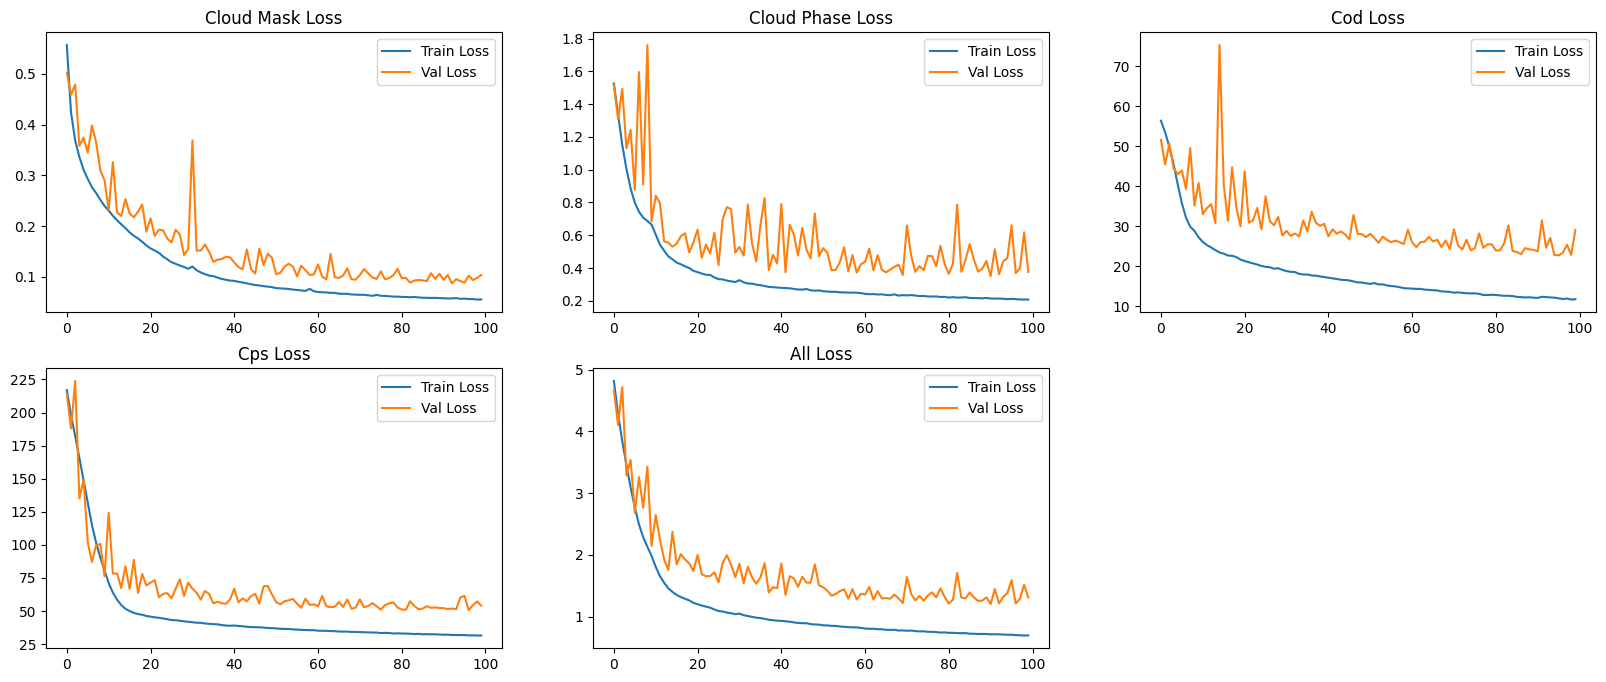

In [9]:
#PLOT LOSS

plt.figure(figsize=(20,8))

plt.subplot(2, 3, 1)
plt.plot(train_mask_losses, label='Train Loss')
plt.plot(val_mask_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_phase_losses, label='Train Loss')
plt.plot(val_phase_losses, label='Val Loss')
plt.title('Cloud Phase Loss')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_cod_losses, label='Train Loss')
plt.plot(val_cod_losses, label='Val Loss')
plt.title('Cod Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_cps_losses, label='Train Loss')
plt.plot(val_cps_losses, label='Val Loss')
plt.title('Cps Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_all_losses, label='Train Loss')
plt.plot(val_all_losses, label='Val Loss')
plt.title('All Loss')
plt.legend()

plt.savefig("./graphs/MultiTaskV3_loss.png")  

plt.show()

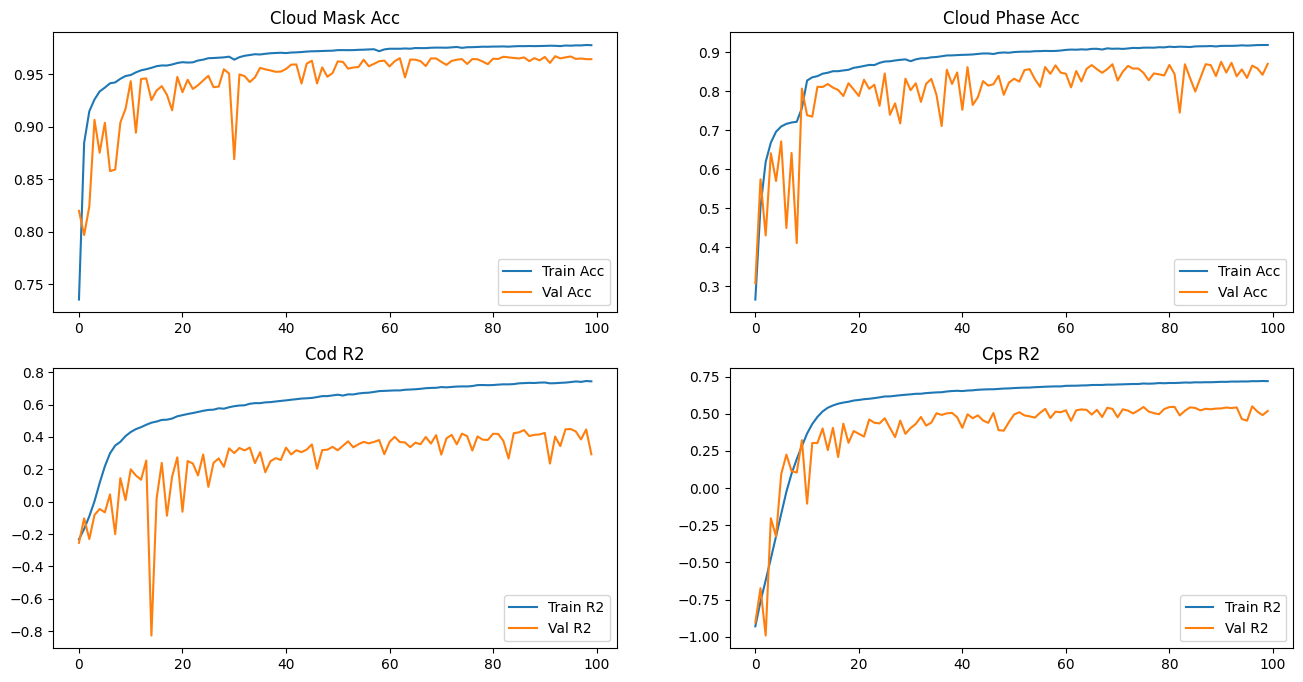

In [10]:
#PLOT ACCURACY

plt.figure(figsize=(16,8))

plt.subplot(2, 2, 1)
plt.plot(train_mask_acc, label='Train Acc')
plt.plot(val_mask_acc, label='Val Acc')
plt.title('Cloud Mask Acc')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_phase_acc, label='Train Acc')
plt.plot(val_phase_acc, label='Val Acc')
plt.title('Cloud Phase Acc')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_cod_r2, label='Train R2')
plt.plot(val_cod_r2, label='Val R2')
plt.title('Cod R2')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_cps_r2, label='Train R2')
plt.plot(val_cps_r2, label='Val R2')
plt.title('Cps R2')
plt.legend()


plt.savefig("./graphs/MultiTaskV3_acc.png")  

plt.show()



In [11]:
# MODEL EVALUATION — CLOUD MASK

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        cloud_mask_target, _, _, _ = unpack_labels(labels)
        cloud_mask_pred, _, _, _ = model(images)

        probs = torch.sigmoid(cloud_mask_pred)
        preds = (probs > 0.5).long()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_mask_target.cpu().numpy())

# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(
    all_labels, all_preds,
    labels=[0, 1],
    digits=3,
    output_dict=True,
    zero_division=0
)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(2)])
supports = np.array([report[str(i)]['support'] for i in range(2)])
iou = f1_scores / (2 - f1_scores)


# Output
print("CLOUD MASK REPORT:\n", classification_report(all_labels, all_preds, labels=[0, 1], digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds, labels=[0, 1]))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))

100%|██████████| 12/12 [00:01<00:00,  6.54it/s]


CLOUD MASK REPORT:
               precision    recall  f1-score   support

           0      0.923     0.898     0.910   5316976
           1      0.972     0.979     0.976  19259024

    accuracy                          0.962  24576000
   macro avg      0.947     0.938     0.943  24576000
weighted avg      0.961     0.962     0.961  24576000

CONFUSION MATRIX:
 [[ 4772557   544419]
 [  398741 18860283]]

IOU: [0.83498833 0.95237394]
Unweighted IoU: 0.8936811347531709
Weighted IoU: 0.9269777608530443


In [12]:
# MODEL EVALUATION — CLOUD PHASE

num_classes = 5

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        _, cloud_phase_target, _, _ = unpack_labels(labels)
        _, cloud_phase_pred, _, _ = model(images)
        preds = torch.argmax(cloud_phase_pred, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_phase_target.cpu().numpy())
        
# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

# Output
print("CLOUD PHASE REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))


100%|██████████| 12/12 [00:01<00:00,  6.47it/s]


CLOUD PHASE REPORT:
               precision    recall  f1-score   support

           0      0.891     0.873     0.882   4044164
           1      0.871     0.937     0.903  10637427
           2      0.861     0.820     0.840   3610760
           3      0.554     0.448     0.496   1072467
           4      0.909     0.850     0.878   5211182

    accuracy                          0.869  24576000
   macro avg      0.817     0.786     0.800  24576000
weighted avg      0.867     0.869     0.867  24576000

CONFUSION MATRIX:
 [[3530740  436480   19539   11337   46068]
 [ 380599 9963237   93893   16644  183054]
 [   1500  449295 2961059  164740   34166]
 [    426  101555  308224  480768  181494]
 [  49407  483235   55410  194175 4428955]]

IOU: [0.78879899 0.82286452 0.72436033 0.32943688 0.78305926]
Unweighted IoU: 0.6897039973198045
Weighted IoU: 0.772813295535213


In [13]:
# MODEL EVALUATION — CLOUD OPTICAL DISTANCE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, cod_target, _ = unpack_labels(labels)
        _, _, cod_pred, _ = model(images)
        
        all_preds.append(cod_pred.cpu().numpy().reshape(-1))
        all_labels.append(cod_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  6.74it/s]


r2: 0.30355387926101685
MSE: 33.011531829833984


In [14]:
# MODEL EVALUATION — CLOUD PARTICLE SIZE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, _, cps_target = unpack_labels(labels)
        _, _, _, cps_pred = model(images)
        
        all_preds.append(cps_pred.cpu().numpy().reshape(-1))
        all_labels.append(cps_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  6.98it/s]


r2: 0.519415020942688
MSE: 53.64166259765625
